In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import torch
from torch_geometric.utils import to_dense_adj
from scipy import linalg
import sys

from stellargraph import datasets
from stellargraph import StellarGraph
from IPython.display import display, HTML

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import SpectralClustering

In [ ]:
# Flatten the 2D array into 1D and create a set to get distinct values 
distinct_values = set(value for row in adjacency_matrix for value in row) 
# Count the number of distinct values 
distinct_count = len(distinct_values)

In [ ]:
adjacency_matrix = adjacency_matrix.numpy()

In [ ]:
type(adjacency_matrix)

In [ ]:
# Count rows where all elements are 0 
empty_rows = np.all(adjacency_matrix == 0, axis=1) 
# Sum of empty rows 
num_empty_rows = np.sum(empty_rows) 
print("Number of completely empty rows:", num_empty_rows)

In [ ]:
# Flatten the 2D array into 1D 
flattened_array = adjacency_matrix.flatten() 
# Convert to set to get distinct values 
distinct_values = set(flattened_array) 
# Count the number of distinct values 
distinct_count = len(distinct_values) 
print("Distinct values:", distinct_values) 
print("Number of distinct values:", distinct_count)

In [ ]:
np.set_printoptions(threshold=sys.maxsize)

In [12]:
def spectral_clustering_on_graph(torch_data, labels, laplacian, number_of_clusters):

    # adjacency_matrix = to_dense_adj(torch_data.edge_index).squeeze()
    # # Convert the PyTorch tensor to a NumPy array
    # adjacency_matrix = adjacency_matrix.numpy()
    # adj_matrix_citeseer_dense = torch_data.todense()
    # adjacency_matrix = torch_data.numpy()

    adjacency_matrix = np.array(torch_data.todense()).squeeze()

    np.fill_diagonal(adjacency_matrix, 0)

    dimension = len(adjacency_matrix)

    # Calculate degree matrix
    degree_matrix = np.sum(adjacency_matrix, axis=0) * np.eye(dimension)

    isolated_nodes = np.where(np.diag(degree_matrix) == 0)[0]
    if len(isolated_nodes) > 0:
        adjacency_matrix = np.delete(adjacency_matrix, isolated_nodes, axis=0)
        adjacency_matrix = np.delete(adjacency_matrix, isolated_nodes, axis=1)
        labels = np.delete(labels, isolated_nodes)
        
    dimension = len(adjacency_matrix)

    # Calculate degree matrix
    degree_matrix = np.sum(adjacency_matrix, axis=0) * np.eye(dimension)
    

    if laplacian == "sym":

        # Normalized Symmetric laplacian matrix
        d_half = linalg.fractional_matrix_power(degree_matrix, -0.5)
        laplacian_matrix_normalized = np.matmul(np.matmul(d_half, adjacency_matrix), d_half)

    if laplacian == "rw":

        # Normalized Random Walk laplacian matrix
        d_inverse = linalg.fractional_matrix_power(degree_matrix, -1)
        laplacian_matrix_normalized = np.matmul(d_inverse, adjacency_matrix)

    if laplacian == "ad":

        # Adaptive laplacian matrix
        degree_vector = np.diag(degree_matrix)  
        D_local = np.zeros_like(degree_vector)  
        
        for i in range(len(degree_vector)):
            neighbors = np.where(adjacency_matrix[i] > 0)[0]
            if len(neighbors) > 0:
                D_local[i] = np.sum(degree_vector[neighbors]) / degree_vector[i]
            else:
                D_local[i] = 0
        
        D_local_matrix = np.diag(D_local)
        D_local_inv = np.linalg.inv(D_local_matrix)
        laplacian_matrix_normalized = np.matmul(np.matmul(D_local_inv, adjacency_matrix), D_local_inv)


    # Calculating eigenvalues and eigenvectors
    e, v = np.linalg.eigh(laplacian_matrix_normalized)

    # index_largest_gap = np.argmax(np.diff(e))
    # nb_clusters = index_largest_gap + 2

    if number_of_clusters == 0:
        eigengaps = np.diff(e)
        index_largest_gap = np.argmax(eigengaps)
        number_of_clusters = index_largest_gap + 1 #fix

    # Eigen features for k
    k = number_of_clusters
    X = v[:, -1*k:]

    # Kmeans
    clustering = KMeans(n_clusters = number_of_clusters)
    clustering.fit(X)
    c_labels = clustering.fit_predict(X)

    # Create a copy of the data object by initializing a new Data instance
    # final_data = Data(
    #     edge_index=torch_data.edge_index,  # edge indices
    # )

    # final_df = torch_data.copy()
    # final_df['c_labels'] = c_labels
    # final_df['labels'] = labels
    
    cluster_labels = clustering.labels_
    
    return silhouette_score(adjacency_matrix, cluster_labels,metric="precomputed"), adjusted_rand_score(labels, cluster_labels),number_of_clusters

In [13]:
# Load the CiteSeer dataset
dataset_citeseer = datasets.CiteSeer()
graph, node_subjects = dataset_citeseer.load()
data = graph.to_adjacency_matrix(weighted=False)
labels = node_subjects.values

# check how data looks like

In [14]:
set(labels)

{'AI', 'Agents', 'DB', 'HCI', 'IR', 'ML'}

In [15]:
laplacian_methods = ["sym", "rw","ad"]

silhouette_scores = []
adjusted_rand_scores = []
clusters = []
laplacian = []


for laplace in laplacian_methods:

    laplacian.append(laplace)

    si, ar, cl = spectral_clustering_on_graph(data, labels, laplace, 0)

    silhouette_scores.append(si)
    adjusted_rand_scores.append(ar)
    clusters.append(cl)

C:\Users\eveli\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\eveli\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\eveli\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\eveli\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureW

In [16]:
experiment_cora = pd.DataFrame(list(zip(laplacian,silhouette_scores,adjusted_rand_scores,clusters)), 
             columns= ["laplacian", "silhouette", "adjusted_rand","clusters"])

experiment_cora

,laplacian,silhouette,adjusted_rand,clusters
0,sym,-1.000000,0.019389,351
1,rw,-0.001225,0.000004,3261
2,ad,-0.004902,0.000014,3256


In [6]:
experiment_cora = pd.DataFrame(list(zip(laplacian,silhouette_scores,adjusted_rand_scores,clusters)), 
             columns= ["laplacian", "silhouette", "adjusted_rand","clusters"])

experiment_cora

,laplacian,silhouette,adjusted_rand,clusters
0,sym,-0.998775,0.021017,351
1,rw,-0.001225,0.000004,3261
2,ad,-0.004902,0.000014,3256


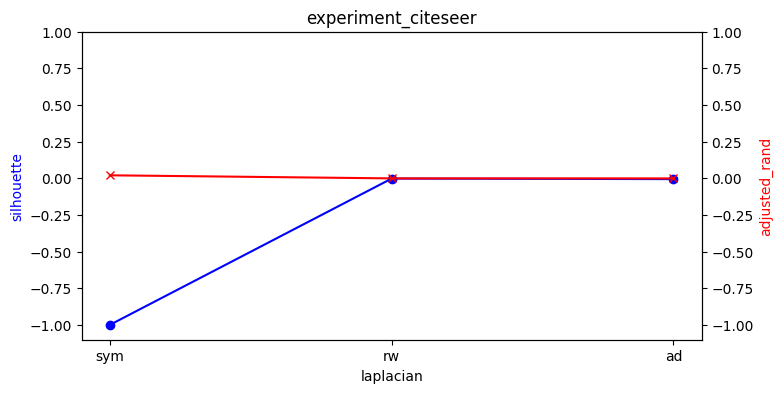

In [7]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Plot time on the first y-axis
ax.plot(experiment_cora['laplacian'], experiment_cora['silhouette'], marker='o', color='b', label='Time (seconds)')

# Create a second y-axis
ax2 = ax.twinx()

# Plot memory on the second y-axis
ax2.plot(experiment_cora['laplacian'], experiment_cora['adjusted_rand'], marker='x', color='r', label='Memory (KB)')

# Set labels and legends
ax.set_xlabel('laplacian')
ax.set_ylabel('silhouette', color='b')
ax2.set_ylabel('adjusted_rand', color='r')

ax.set_ylim(-1.1, 1)
ax2.set_ylim(-1.1, 1)  # Adjust the multiplier as needed


# Add legends
# ax.legend(loc='upper left')
# ax2.legend(loc='upper right')

# Show the plot
plt.title('experiment_citeseer')
plt.show()

In [ ]:
# run spectral on sklearn